In [1]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import pandas as pd
import requests
import os.path as osp
import pickle
import random
import numpy as np
from pathlib import Path
import sys
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import shutil
from sklearn.model_selection import train_test_split

c:\users\aphri\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dataset_path = "data/cleaned_target_furniture_dataset.csv"
finetune_data_path = "C:/Users/aphri/Documents/t0002/work/data/w210_data/finetune_data"
image_storage = "C:/Users/aphri/Documents/t0002/work/data/w210_data/target_images"
train_data_path = osp.join(finetune_data_path, "train_data.pkl")
subset_data_path = osp.join(finetune_data_path, "subset_data.pkl")
model_path = osp.join(finetune_data_path, "finetuned_model.pt")

Path(finetune_data_path).mkdir(parents=True, exist_ok=True)

In [3]:
def read_pickle(dir):
    with open(dir, 'rb') as handle:
        b = pickle.load(handle)
    return b


def write_pickle(dir, data):
    with open(dir, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
def image_path(uid):
    return osp.join(image_storage, f"{uid}.jpg")

In [5]:
def combine_category(x):
    res = x["sub_category_1"]
    if not pd.isna(x["sub_category_2"]):
        res += ", " + x["sub_category_2"]
    if not pd.isna(x["sub_category_3"]):
        res += ", " + x["sub_category_3"]
    return res

In [6]:
def clean_data(d1):
    d1 = d1[d1["primary_category"] == "Furniture"]
    d1 = d1[~(d1["primary_category"].isna() & d1["sub_category_1"].isna() & d1["sub_category_2"].isna() & d1["sub_category_3"].isna())]
    d1 = d1[~(d1["sub_category_1"].isna() & d1["sub_category_2"].isna() & d1["sub_category_3"].isna())]
    d1 = d1[~d1["description"].isna()]
    d1 = d1[~d1["colors"].isna()]
    d1["colors"] = d1["colors"].astype(str)
    d1["combined_category"] = d1.apply(combine_category, axis=1)
    return d1

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [8]:
d1 = pd.read_csv(dataset_path)
d1 = clean_data(d1)

<AxesSubplot: xlabel='combined_category'>

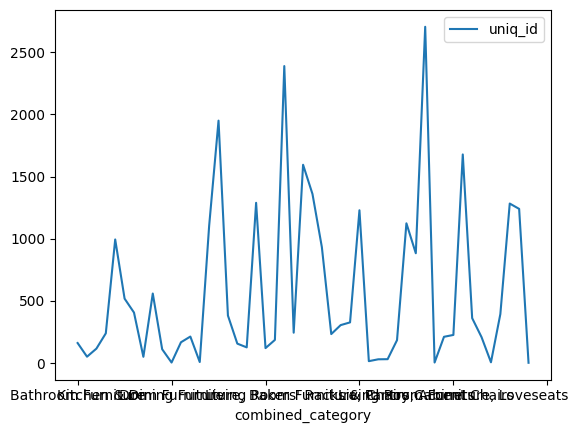

In [10]:
s1 = d1[["combined_category", "uniq_id"]].groupby("combined_category").count()
s1.plot()

In [11]:
s1[s1.uniq_id == s1.uniq_id.max()]

,uniq_id
combined_category,
"Living Room Furniture, End & Side Tables",2705


In [12]:
s1.loc["Home Office Furniture, Bookshelves & Bookcases"]

uniq_id    1103
Name: Home Office Furniture, Bookshelves & Bookcases, dtype: int64

In [13]:
if not osp.exists(subset_data_path):
    d2 = d1[d1["combined_category"] == "Home Office Furniture, Bookshelves & Bookcases"]
    write_pickle(osp.join(finetune_data_path, "subset_data.pkl"), d2)
else:
    d2 = read_pickle(subset_data_path)

In [14]:
len(d2)

1103

In [15]:
d2.columns

Index(['title', 'url', 'brand', 'main_image', 'sku', 'description',
       'raw_description', 'gtin13', 'currency', 'price', 'availability',
       'availableDeliveryMethod', 'available_branch', 'primary_category',
       'sub_category_1', 'sub_category_2', 'sub_category_3', 'images',
       'raw_specifications', 'specifications', 'highlights', 'raw_highlights',
       'uniq_id', 'scraped_at', 'dimensions', 'weight', 'assembly_details',
       'material', 'colors', 'combined_category'],
      dtype='object')

In [16]:
d2s = d2[["title", "uniq_id"]]

In [17]:
if not osp.exists(train_data_path):
    eimage_list = []
    etext_list = []
    for idx, row in d2s.iterrows():
        text = row.title
        image = image_path(row.uniq_id)

        image = preprocess(Image.open(image)).unsqueeze(0)
        text = clip.tokenize(text)

        eimage_list.append(image)
        etext_list.append(text)

    df = pd.DataFrame(data={
        "encoded_image": eimage_list,
        "encoded_text": etext_list
    })
    
    write_pickle(train_data_path, df)
    
else:
    df = read_pickle(train_data_path)

In [18]:
train_data,test_data = train_test_split(df)

In [19]:
len(train_data)

827

In [20]:
len(test_data)

276

In [32]:
def calc_loss(data, criterion, device):
    encoded_images = torch.cat(list(data["encoded_image"].values)).to(device)
    encoded_texts = torch.cat(list(data["encoded_text"].values)).to(device)

    logits_per_image, logits_per_text = model(encoded_images, encoded_texts)

    # during training # images == # texts, so calc only once
    n_classes = logits_per_image.shape[0]
    device = device
    labels = torch.arange(n_classes, device=device, dtype=torch.long)
    
    loss_image = criterion(logits_per_image, labels)
    loss_text = criterion(logits_per_text, labels)
    curr_loss = (loss_image + loss_text)/2
    
    return curr_loss


def train(model, train_data, criterion, device, optimizer):
    
    model.train()
    total_loss = 0
    total_count = 0
    
    # print(f"training...")

    optimizer.zero_grad()
    curr_loss = calc_loss(train_data, criterion, device)

    curr_loss.backward()
    optimizer.step()

    total_loss = curr_loss.item()
    total_count = len(train_data)

    print(f"training average loss: {total_loss/total_count}")
            
            
def evaluate(model, test_data, criterion, device):
    
    model.eval()
    total_loss = 0
    total_count = 0
    
    with torch.no_grad():
        # print(f"evaluating...")

        curr_loss = calc_loss(test_data, criterion, device)

        total_loss = curr_loss.item()
        total_count = len(test_data)

        print(f"evaluation average loss: {total_loss/total_count}")
    
    
def run_epoch(
    model,
    train_data,
    test_data,
    criterion,
    device,
    optimizer,
    n_epoch,
    seed=1234,
):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    for n in range(n_epoch):
        print(f"training epoch: {n}")
        train(model, train_data, criterion, device, optimizer)
        evaluate(model, test_data, criterion, device)

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.00005
betas = (0.9, 0.98)
eps = 1e-6
weight_decay = 0.2
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    betas=betas, 
    eps=eps, 
    weight_decay=weight_decay
)
n_epoch = 20

run_epoch(model, train_data, test_data, criterion, device, optimizer, n_epoch)
torch.save(
    model.state_dict(),
    str(model_path)
)